In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import PIL
import tqdm
import warnings

from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")

#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

In [2]:
from google.colab import drive

In [3]:
drive.mount('MyDrive')

Mounted at MyDrive


In [4]:
data_root_dir = 'MyDrive/MyDrive/Midterms Exam/Portraits Dataset'

In [5]:
#Importing data
dataset = (data_root_dir)
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(dataset, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


In [6]:
latent_dim = 100
g_resolution = 2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

(-0.5, 63.5, 63.5, -0.5)

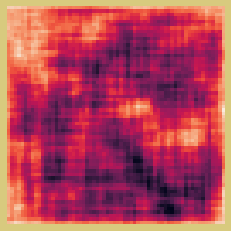

In [7]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)

#Plotting the image output of generator without training 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

In [8]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [9]:
#for the random image generated
Discriminator = discriminator(Generated_Portrait)
print (Discriminator)

tf.Tensor([[0.4989335]], shape=(1, 1), dtype=float32)


In [10]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [11]:
#Defining the number of epochs
epochs = 15

#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)

#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/15
65/65 [==============================] - 143s 623ms/step - d_loss: 0.4183 - g_loss: 0.7904
Epoch 2/15
65/65 [==============================] - 40s 545ms/step - d_loss: 0.2193 - g_loss: 1.4045
Epoch 3/15
65/65 [==============================] - 41s 545ms/step - d_loss: 0.0733 - g_loss: 3.0847
Epoch 4/15
65/65 [==============================] - 40s 541ms/step - d_loss: 0.0192 - g_loss: 4.9794
Epoch 5/15
65/65 [==============================] - 40s 548ms/step - d_loss: -0.0097 - g_loss: 7.5751
Epoch 6/15
65/65 [==============================] - 42s 569ms/step - d_loss: -0.0870 - g_loss: 13.5332
Epoch 7/15
65/65 [==============================] - 40s 538ms/step - d_loss: -0.2491 - g_loss: 31.0895
Epoch 8/15
65/65 [==============================] - 40s 538ms/step - d_loss: -0.8308 - g_loss: 87.2216
Epoch 9/15
65/65 [==============================] - 42s 568ms/step - d_loss: -2.6763 - g_loss: 262.9208
Epoch 10/15
65/65 [==============================] - 40s 537ms/step - d_loss: -9

In [16]:
#Number of images to be generated
num_image = 15

#A function to generate and save images
def Portrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_image, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_image):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Portraits{:02d}.png".format(i)) 
    return 


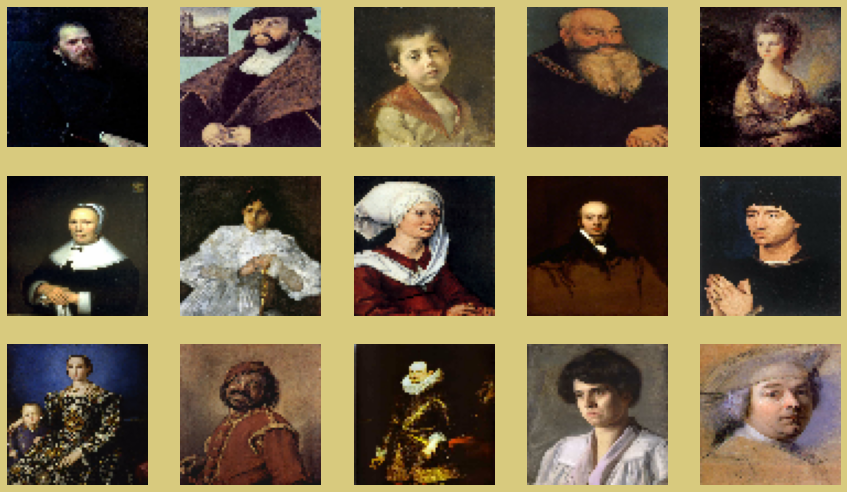

In [23]:
#Defing a function to see images
def Show_Image(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(15):
            ax = plt.subplot(5, 5, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset            
Show_Image(data)